<a href="https://colab.research.google.com/github/hitesh-bhatnagar/Transfer_Learning/blob/main/09_Transfer_Learning_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

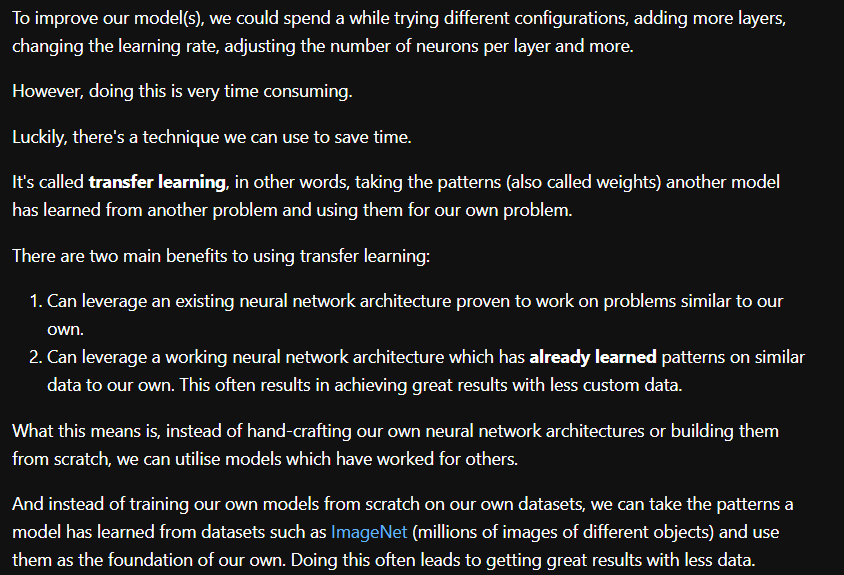

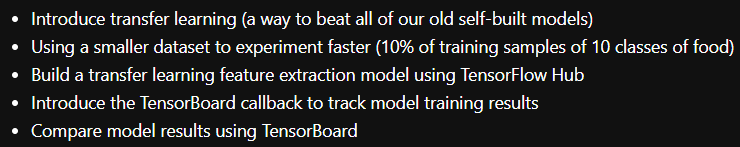

## First change the runtime to tpu or gpu  

In [1]:
import datetime
print(f"Notebok last run {datetime.datetime.now()}")

Notebok last run 2024-07-28 09:50:31.223564


In [2]:
# Are we usign a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-07-28 09:50:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 142.250.152.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   262MB/s    in 0.6s    

2024-07-28 09:50:32 (262 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip","r")
zip_ref.extractall()
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [5]:
import os
os.listdir()

['.config',
 '10_food_classes_10_percent.zip',
 '__MACOSX',
 '10_food_classes_10_percent',
 'sample_data']

In [6]:
# walk through 10 percent data directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

In [7]:
# SEtup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Image_Shape = (224,224)
Batch_size = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent  =train_datagen.flow_from_directory(train_dir,
                                                       target_size=Image_Shape,
                                                       batch_size=Batch_size,
                                                       class_mode="categorical")

print("Testing images: ")

test_data = train_datagen.flow_from_directory(test_dir,
                                                       target_size=Image_Shape,
                                                       batch_size=Batch_size,
                                                       class_mode="categorical")

print("")
print("")
print("75 images on the training dataset belonging to 10 classes (75 per class) & 2500 images in the test set belonging to 10 classes (250 per class)")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


75 images on the training dataset belonging to 10 classes (75 per class) & 2500 images in the test set belonging to 10 classes (250 per class)


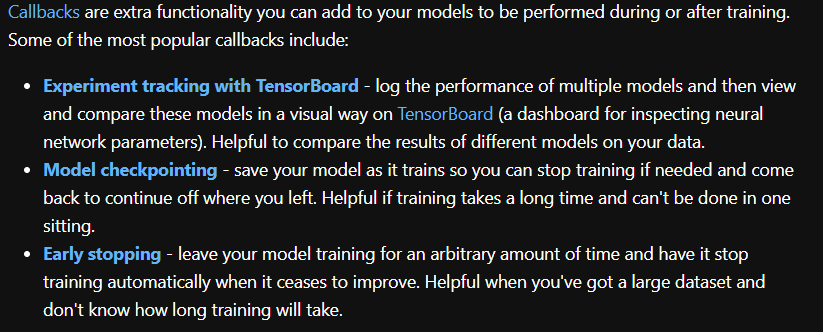

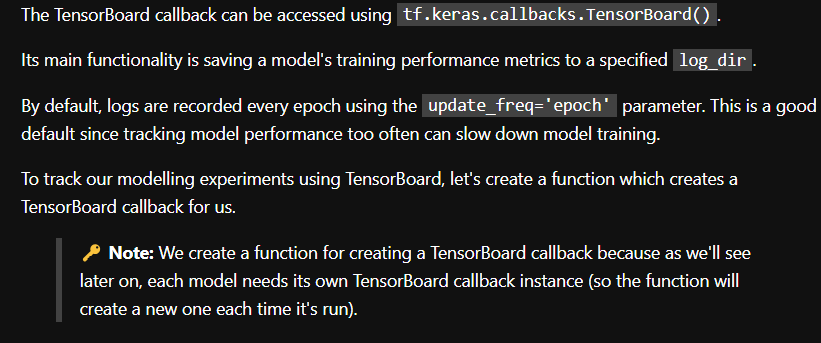

In [8]:
# Create tensorboard callback (finctionized because need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


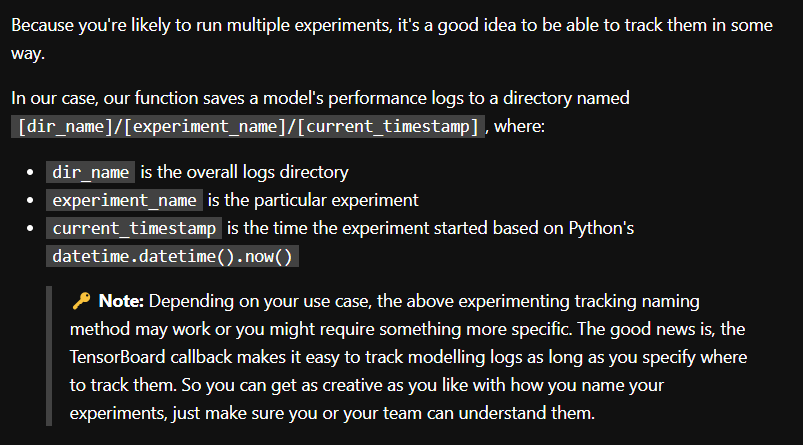

# Different types of tranfer learning  :

## As is :
      is when you take a pretrained models as it is & apply it to your task without any changes.

## Feature extraction :
      is when you take the underlying patters( so called weights) a pretrained model has learned and adjust its output to be more suited to your problem
Note --> Only the top few layers become trainable the rest remain frozen

## Fine-tuning :
      when you take the underlying patters of a pretrained model and adjust then to your own problem
      


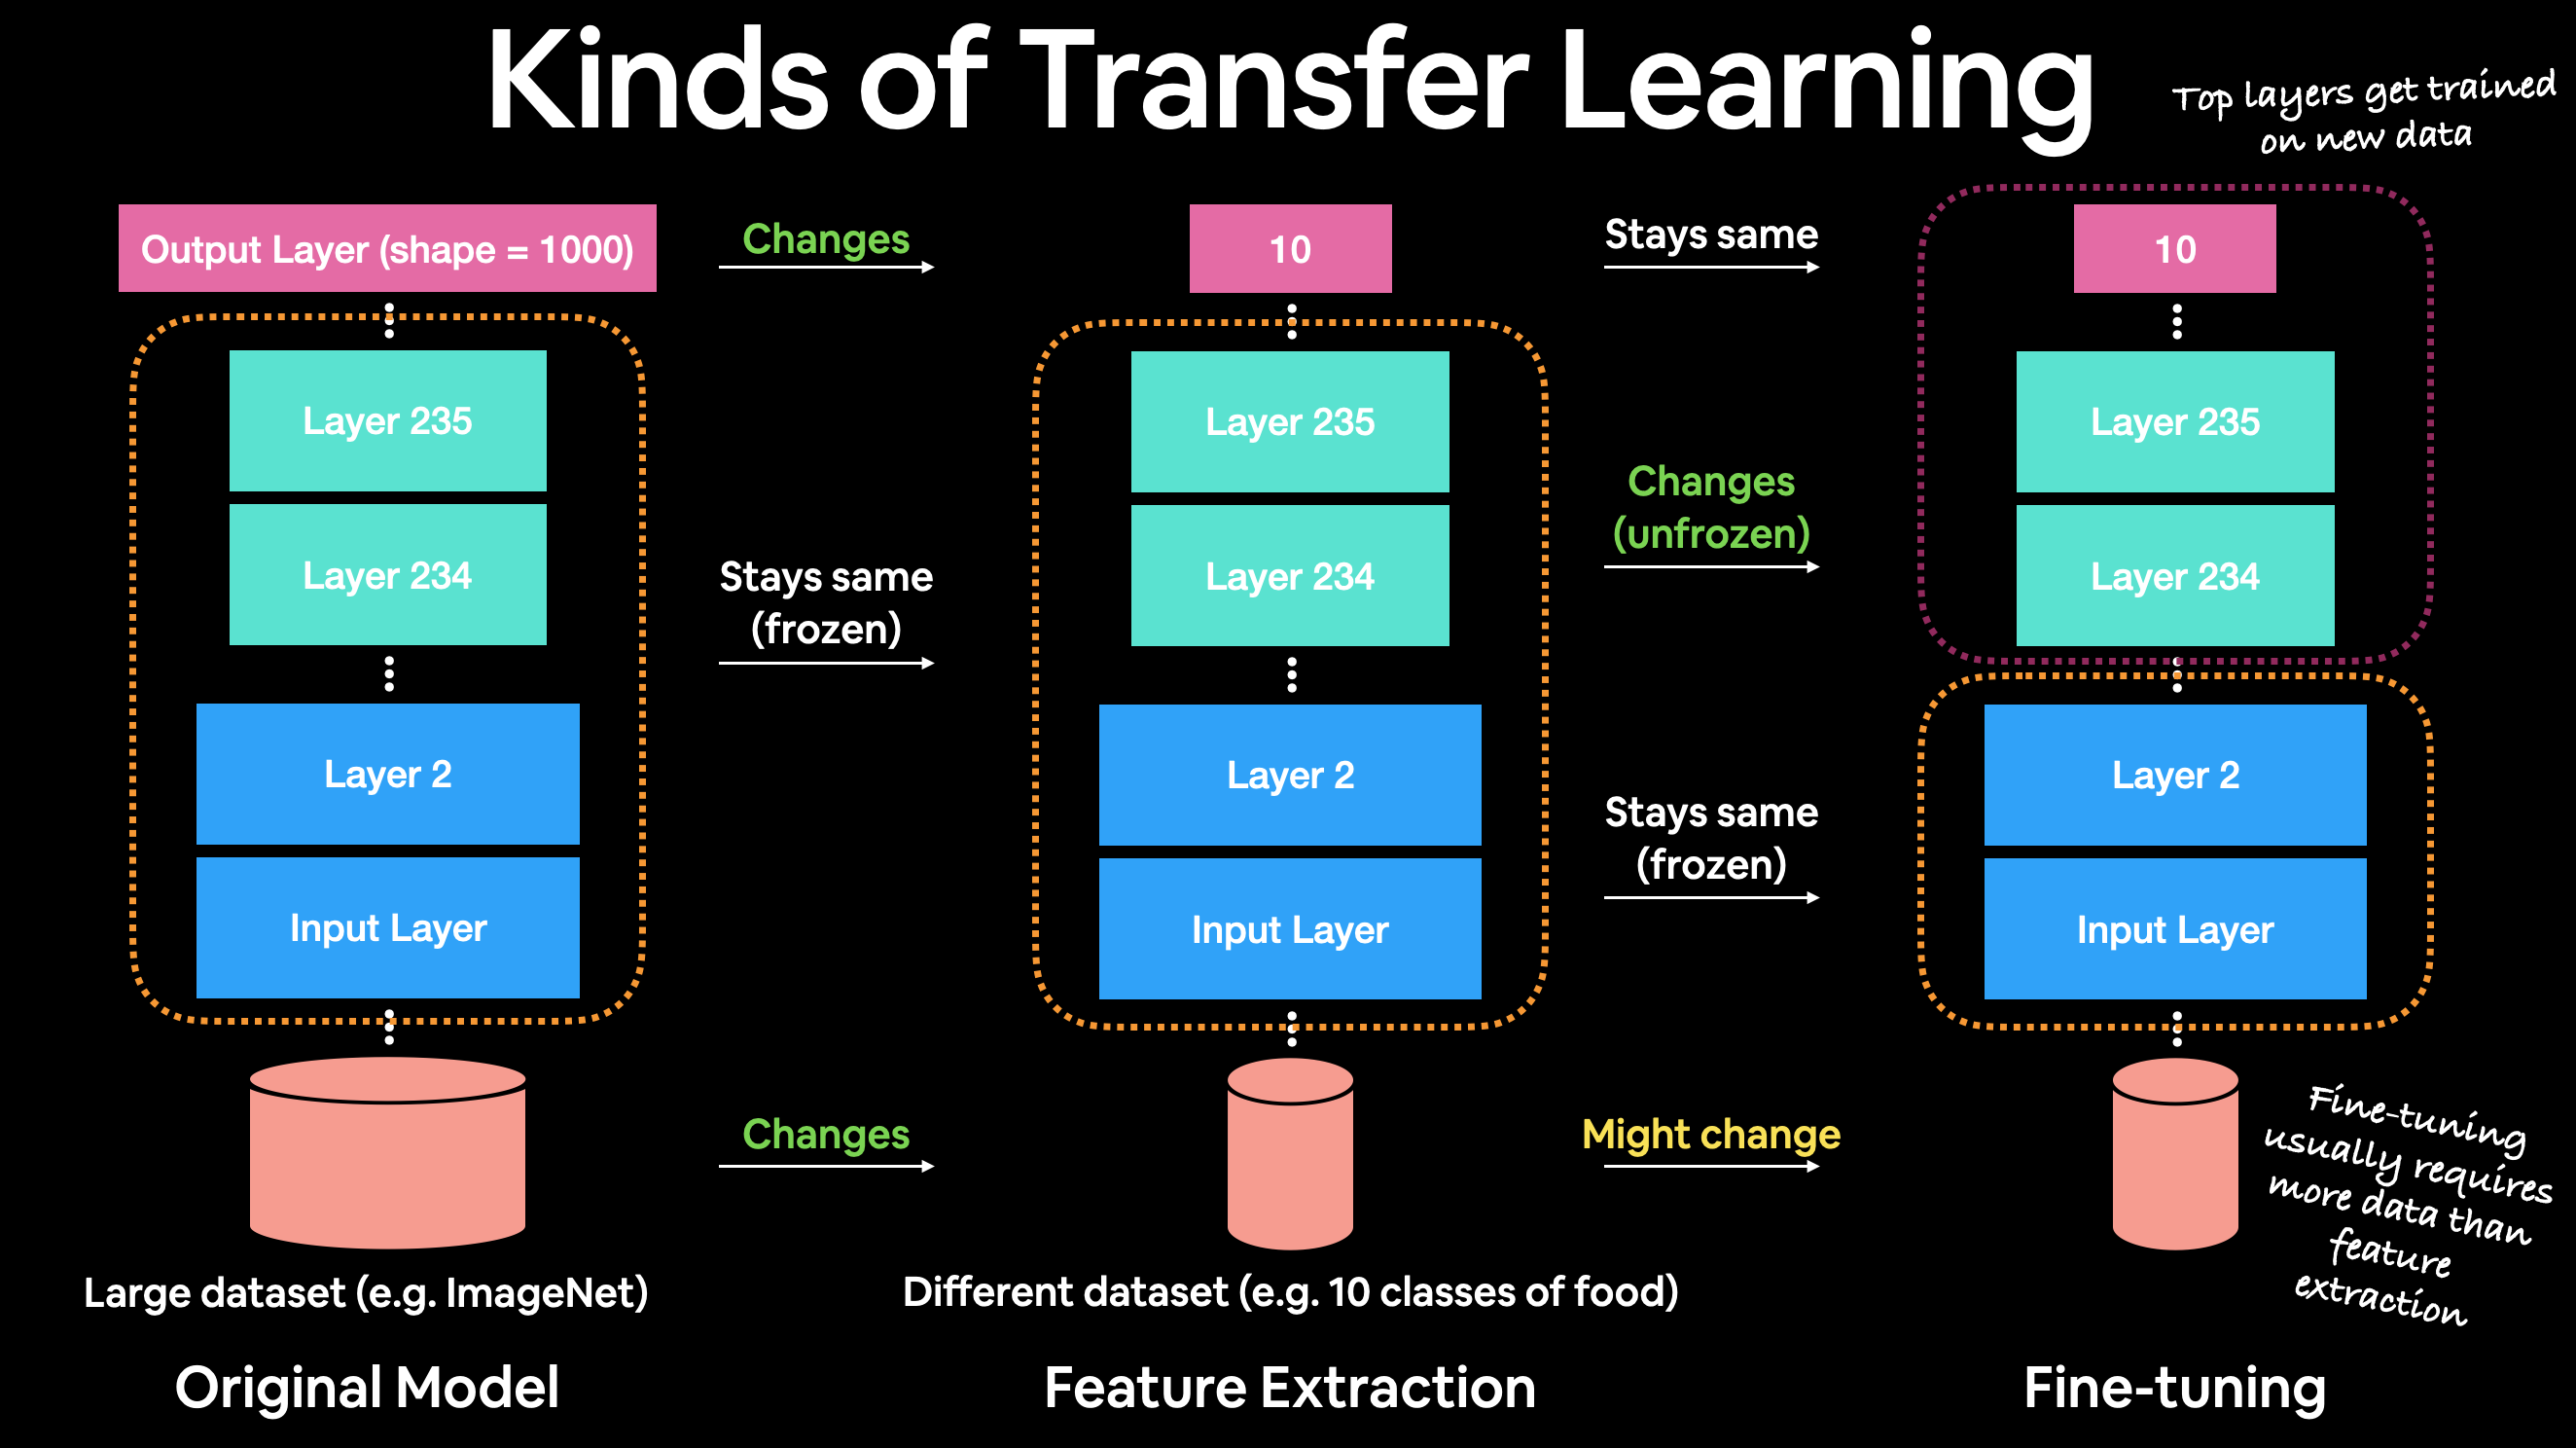

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Now we'll get the feature vector URLs of two common computer vision architectures , [EfficientNetB0 (2019)](https://www.kaggle.com/models/tensorflow/efficientnet/tensorFlow2/b0-feature-vector/1?tfhub-redirect=true)  and [ResNetV250 (2016)](https://www.kaggle.com/models/google/resnet-v2/tensorFlow2/50-feature-vector/1?tfhub-redirect=true) from TensorFlow Hub


we are comparing them to see which performs better

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"



These urls link to a saved pretrained model on Tensorflow Hub

When we use them in our model the model will automatically be downloaded for us to use.

We use ``` KerasLayer()``` model inside the Tensorflow Hub library


Since for comparing two models, we'll create a function ```create_model ```.
This function will take a model's Tensorflow Hub URL instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [11]:
def create_model(model_url , num_classes = 10):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default
      to 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,   # Freeze the underlying patterns
                                           name="feature_extraction_layer",
                                           input_shape=Image_Shape+(3,))    # define the input shape

  # Create our own model

  model = tf.keras.Sequential([
    feature_extractor_layer,      # use the feature extraction layer as the base
    layers.Dense(num_classes, activation="softmax", name="output_layer")  # create our own putput layer
  ])

  return model

In [12]:
# create model

resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

# compile
resnet_model.compile(loss = 'categorical_crossentropy',
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

When fitting the model we'll add Tensorboard callback so we can tract the performace of model

In [13]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),

                                  # add Tensorboard callback to track model's performace
                                  callbacks = [create_tensorboard_callback(dir_name = "tensorflow_hub",     # save experiment logs
                                                                            experiment_name = "resnet50V2")])       # name of the log file


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240728-095055
Epoch 1/5
24/24 [==============================] - 45s 2s/step - loss: 1.8273 - accuracy: 0.3947 - val_loss: 1.1428 - val_accuracy: 0.6428
Epoch 2/5
24/24 [==============================] - 40s 2s/step - loss: 0.8537 - accuracy: 0.7307 - val_loss: 0.8262 - val_accuracy: 0.7424
Epoch 3/5
24/24 [==============================] - 42s 2s/step - loss: 0.5978 - accuracy: 0.8293 - val_loss: 0.7374 - val_accuracy: 0.7620
Epoch 4/5
24/24 [==============================] - 40s 2s/step - loss: 0.4595 - accuracy: 0.8840 - val_loss: 0.6918 - val_accuracy: 0.7736
Epoch 5/5
24/24 [==============================] - 40s 2s/step - loss: 0.3664 - accuracy: 0.9147 - val_loss: 0.6632 - val_accuracy: 0.7876


In [14]:
# Plotting our model's training curve

import matplotlib.pyplot as plt

# plot the training and validation data separately

def plot_loss_curves(history) :

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # plot loss
  plt.plot(epochs,loss, label = 'training loss')
  plt.plot(epochs , val_loss, label = 'validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  # plot accuracy

  plt.figure()
  plt.plot(epochs, accuracy, label = 'training accuracy')
  plt.plot(epochs , val_accuracy, label = 'validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

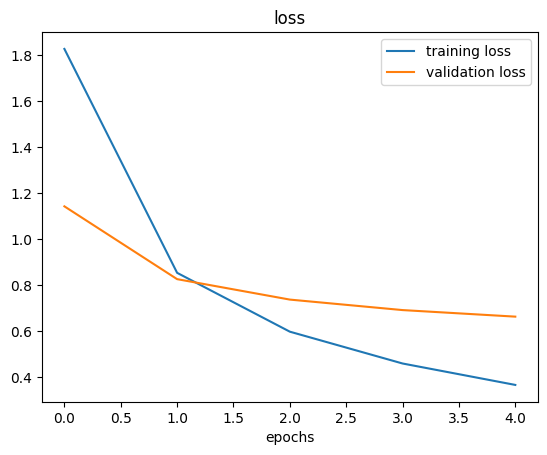

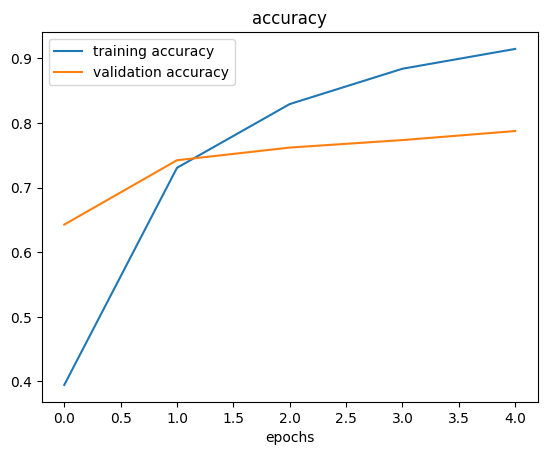

In [15]:
plot_loss_curves(resnet_history)

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


We have trained ResNetV250 model now do the dame with EfficientNetB0 model

In [17]:
# create model

efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = train_data_10_percent.num_classes)

# compile efficientnet model

efficientnet_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

# fit efficient model

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                        epochs = 5,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',

                                                                                 # track logs under different experiment
                                                                                 experiment_name = 'efficientnetB0')])


Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240728-095432
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.7951 - accuracy: 0.4680 - val_loss: 1.2650 - val_accuracy: 0.7228
Epoch 2/5
24/24 [==============================] - 32s 1s/step - loss: 1.0324 - accuracy: 0.7707 - val_loss: 0.8559 - val_accuracy: 0.8064
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.7405 - accuracy: 0.8333 - val_loss: 0.6917 - val_accuracy: 0.8384
Epoch 4/5
24/24 [==============================] - 32s 1s/step - loss: 0.5942 - accuracy: 0.8680 - val_loss: 0.6078 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 32s 1s/step - loss: 0.5040 - accuracy: 0.9000 - val_loss: 0.5562 - val_accuracy: 0.8536


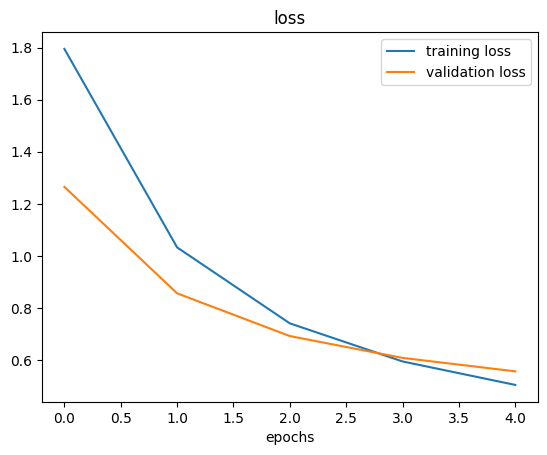

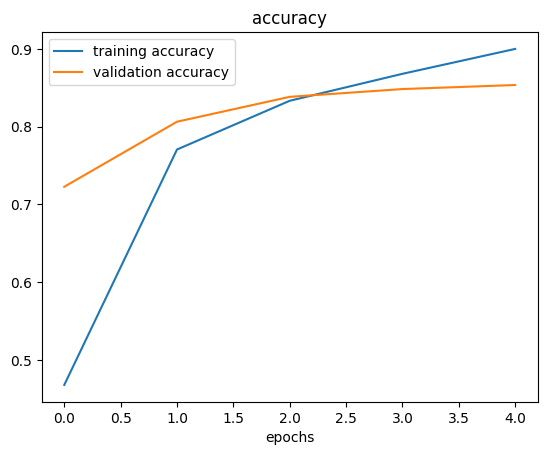

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [20]:
# upload Tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorboard.dev/ is no longer
supported.

TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************


In [21]:
resnet_model.save('/content/resnet_model.h5')
efficientnet_model.save('/content/EfficientNet_model.h5')
print('Models saved successfully')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Models saved successfully


In [23]:
import os
os.listdir('/content')

['.config',
 'resnet_model.h5',
 'tensorflow_hub',
 '10_food_classes_10_percent.zip',
 '__MACOSX',
 'EfficientNet_model.h5',
 '10_food_classes_10_percent',
 'sample_data']